In [119]:
import json
import pandas as pd
from datetime import timedelta
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

## Google fit 

In [34]:
def step_counts():
    
    # import data
    with open('data/derived_com.google.step_count.delta_com.google(2).json') as file:
        steps = json.load(file)
        data = steps['Data Points']
        steps_dict = {}
    
    # convert time nanos to datetime
    for index in range(0,len(data)):
        start = datetime.fromtimestamp(data[index]['startTimeNanos'] // 1000000000).strftime('%Y-%m-%d %H:%M:%S')
        end = datetime.fromtimestamp(data[index]['endTimeNanos'] // 1000000000).strftime('%Y-%m-%d %H:%M:%S')
        steps_dict[index] = [start,end,data[index]['fitValue'][0]['value']['intVal']]
        df = pd.DataFrame.from_dict(steps_dict, columns=['start','end','steps'], orient='index')
    
    df['start'] = pd.to_datetime(df['start']).dt.tz_localize('Europe/Rome')
    df['end'] = pd.to_datetime(df['end']).dt.tz_localize('Europe/Rome')
    df['interval'] = df.end - df.start
    df['session'] = None
    
    return df

In [35]:
steps_df = step_counts()
steps_df

,start,end,steps,interval,session
0,2021-04-03 15:18:35+02:00,2021-04-03 15:18:54+02:00,7,00:00:19,None
1,2021-04-03 15:19:45+02:00,2021-04-03 15:20:45+02:00,12,00:01:00,None
2,2021-04-03 15:20:45+02:00,2021-04-03 15:21:49+02:00,50,00:01:04,None
3,2021-04-03 15:21:49+02:00,2021-04-03 15:22:55+02:00,106,00:01:06,None
4,2021-04-03 15:22:55+02:00,2021-04-03 15:23:56+02:00,117,00:01:01,None
...,...,...,...,...,...
892,2021-04-09 19:31:17+02:00,2021-04-09 19:32:14+02:00,2,00:00:57,None
893,2021-04-09 19:32:14+02:00,2021-04-09 19:33:00+02:00,2,00:00:46,None
894,2021-04-09 19:33:00+02:00,2021-04-09 19:33:48+02:00,2,00:00:48,None
895,2021-04-09 20:46:41+02:00,2021-04-09 20:47:41+02:00,1,00:01:00,None


In [36]:
def find_session():
    
    # extract info from each running session file
    session_dict = {'start':[],'end':[],'duration_tot':[],'steps_tot':[]}
    for session in os.listdir(os.getcwd()+'/data/'):
        if session.endswith("RUNNING.json"):
            with open('data/'+session) as file:
                session_info = json.load(file)
                session_dict['start'].append(session_info['startTime'])
                session_dict['end'].append(session_info['endTime'])
                session_dict['duration_tot'].append(session_info['duration'])
                session_dict['steps_tot'].append(session_info['aggregate'][2]['intValue'])
    
    df = pd.DataFrame.from_dict(session_dict)
    df.index += 1 
    df['start'] = pd.to_datetime(df['start']).dt.tz_convert('Europe/Rome')
    df['end'] = pd.to_datetime(df['end']).dt.tz_convert('Europe/Rome')
    
    return df

In [37]:
session_df = find_session()
session_df

,start,end,duration_tot,steps_tot
1,2021-04-05 10:39:23.966000+02:00,2021-04-05 11:02:43.482000+02:00,1398.050s,3535
2,2021-04-08 15:06:59.931000+02:00,2021-04-08 15:28:06.356000+02:00,1237.850s,3178
3,2021-04-09 17:07:14.891000+02:00,2021-04-09 17:29:12.493000+02:00,1316.320s,3326
4,2021-04-06 19:17:04.026000+02:00,2021-04-06 19:40:53.954000+02:00,1429.020s,3683


In [38]:
def merge(steps_df,sessions_df):
    
    # intersect timestamps to associate step counts to sessions 
    for idx in session_df.index:
        for i, row in steps_df.iterrows():
            if row.start >= session_df.loc[idx].start and row.end <= session_df.loc[idx].end:
                steps_df.at[i,'session'] = idx
    
    df = steps_df[pd.isnull(steps_df.session) == False]
    
    return df

In [39]:
steps_session = merge(steps_df,session_df)

In [142]:
steps_session

,start,end,steps,interval,session
216,2021-04-05 10:39:29+02:00,2021-04-05 10:40:30+02:00,126,00:01:01,1
217,2021-04-05 10:40:30+02:00,2021-04-05 10:41:31+02:00,153,00:01:01,1
218,2021-04-05 10:41:31+02:00,2021-04-05 10:42:32+02:00,154,00:01:01,1
219,2021-04-05 10:42:32+02:00,2021-04-05 10:43:33+02:00,154,00:01:01,1
220,2021-04-05 10:43:33+02:00,2021-04-05 10:44:34+02:00,156,00:01:01,1
...,...,...,...,...,...
855,2021-04-09 17:23:19+02:00,2021-04-09 17:24:20+02:00,158,00:01:01,3
856,2021-04-09 17:24:20+02:00,2021-04-09 17:25:21+02:00,157,00:01:01,3
857,2021-04-09 17:25:21+02:00,2021-04-09 17:26:22+02:00,155,00:01:01,3
858,2021-04-09 17:26:22+02:00,2021-04-09 17:27:23+02:00,156,00:01:01,3


## Arduino SJ 
(work in progress)

In [129]:
# handmade file
sessions_raw = pd.read_csv('data/records_ASJ.csv', index_col=0)
sessions_raw

,date,time,duration
session,,,
1,05/04/21,10:39:00 AM,23min 31s
2,06/04/21,07:17:00 PM,23min 35s
3,08/04/21,03:03:00 PM,22min 57s
4,09/04/21,05:07:00 PM,21min 33s


In [219]:
def ASJdata(runner):
    
    sessions = pd.read_csv('data/records_ASJ.csv', index_col=0)

    start = []
    end = []
    table= []

    for idx in sessions.index:
        
        # import 
        raw_data = pd.read_csv('data/'+runner+'_run'+str(idx)+'_ArduinoSJ.csv', index_col=0, names=['AccY','AccZ','AccL','Decibel','AccX'],header=0)
        
        # extract info
        mins = int(sessions.duration.loc[idx].split(' ')[0][:2])
        secs = int(sessions.duration.loc[idx].split(' ')[1][:-1])
        
        # move to datetime format
        Date = sessions.date.loc[idx].split('/')
        Time = sessions.time.loc[idx].split(':')
        DT = datetime(int('20'+str(Date[-1])), int(Date[1]), int(Date[0]), int(Time[0]), int(Time[1]))
        start.append(DT)
        end.append(DT + timedelta(minutes=mins, seconds=secs))          
        
        # call summary on each session
        table = summary(mins,secs,raw_data,table,idx)
    
    # merge into dataframe
    ASJ_data = pd.DataFrame(table, columns=['Session','AccX_max', 'AccX_min',  'AccX_avg',
                            'AccY_max', 'AccY_min', 'AccY_avg',
                            'AccZ_max',  'AccZ_min', 'AccZ_avg', 
                            'Linear_max', 'Linear_min', 'Linear_avg',
                            'Decibel_max','Decibel_min','Decibel_avg' ] )
    
    # save sessions with datetime format
    sessions['end'] = end
    sessions['start'] = start
    sessions = sessions.drop(columns = ['date','time','duration'])
    
    return ASJ_data, sessions


In [220]:
def summary(mins,secs,raw_data,table,idx):
    
    '''this function summarizes the data collected in one minute (can be merged with google data I think)'''
    
    # calculates how many rows should be considered for the summary
    time = mins * 60 + secs
    nrows = math.ceil(raw_data.shape[0]/time)
    row_0 = 0
    row_last = nrows
    
    # save max min and avg for each sensor
    while row_0 + row_last < raw_data.shape[0]:
        M = raw_data[row_0:row_last].max(axis=0)
        m = raw_data[row_0:row_last].min(axis=0)
        avg = raw_data[row_0:row_last].mean(axis=0)
        line = [idx]
        for col in ['AccX', 'AccY', 'AccZ', 'AccL', 'Decibel']:
            line+=[M[col], m[col], avg[col]]
        table.append(line)
        row_0 += nrows
        row_last += nrows
    
    return table

In [221]:
ASJ_data, sessions = ASJdata('martina')

In [222]:
ASJ_data

,Session,AccX_max,AccX_min,AccX_avg,AccY_max,AccY_min,AccY_avg,AccZ_max,AccZ_min,AccZ_avg,Linear_max,Linear_min,Linear_avg,Decibel_max,Decibel_min,Decibel_avg
0,1,1.421417,-2.597244,-0.667766,5.452454,2.271759,3.943421,11.097275,6.146072,8.996831,2.323268,0.146548,1.345166,34.741636,8.851226,21.375759
1,1,0.758224,-3.199387,-1.105911,7.662308,-1.637970,3.890271,13.206573,6.031143,8.786304,3.547091,0.749523,1.827644,52.020684,7.998941,18.919843
2,1,1.359177,-3.467545,-0.807486,6.930878,3.382675,5.017531,13.619568,6.390274,8.432473,3.976351,0.264283,1.728454,33.059783,7.071803,15.155446
3,1,0.913849,-3.213760,-1.009189,7.116425,0.447388,4.085398,15.757584,4.772995,8.595744,7.047899,0.650066,1.999453,70.235681,8.245384,43.775195
4,1,2.605347,-0.928482,0.470175,4.633636,0.875946,2.795387,14.610764,4.927414,10.000732,3.792347,0.839687,1.847962,43.923880,8.401537,22.576140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,4,9.309113,-10.258698,-0.468131,33.261108,-9.037247,11.651048,9.592514,-4.053238,2.368316,14.262555,4.040538,9.019370,71.055118,39.028092,62.353261
2732,4,11.065262,-10.268265,1.707680,26.562134,-6.553268,9.961356,6.663208,-4.382431,2.337719,16.232705,3.650001,8.628390,68.410332,29.298706,43.527758
2733,4,11.566849,-10.500504,-0.067862,30.981827,-8.844513,14.189472,13.104813,-5.753113,2.541655,16.805584,2.293669,10.254368,71.134083,30.099242,54.611321
2734,4,10.403275,-11.786194,-1.959163,28.373352,-6.389267,11.753402,10.029465,-4.011337,2.189049,12.384919,3.157853,8.313212,68.866349,23.851223,41.771423


In [223]:
sessions

,end,start
session,,
1,2021-04-05 11:02:31,2021-04-05 10:39:00
2,2021-04-06 07:40:35,2021-04-06 07:17:00
3,2021-04-08 03:25:57,2021-04-08 03:03:00
4,2021-04-09 05:28:33,2021-04-09 05:07:00


### Check time series

<AxesSubplot:>

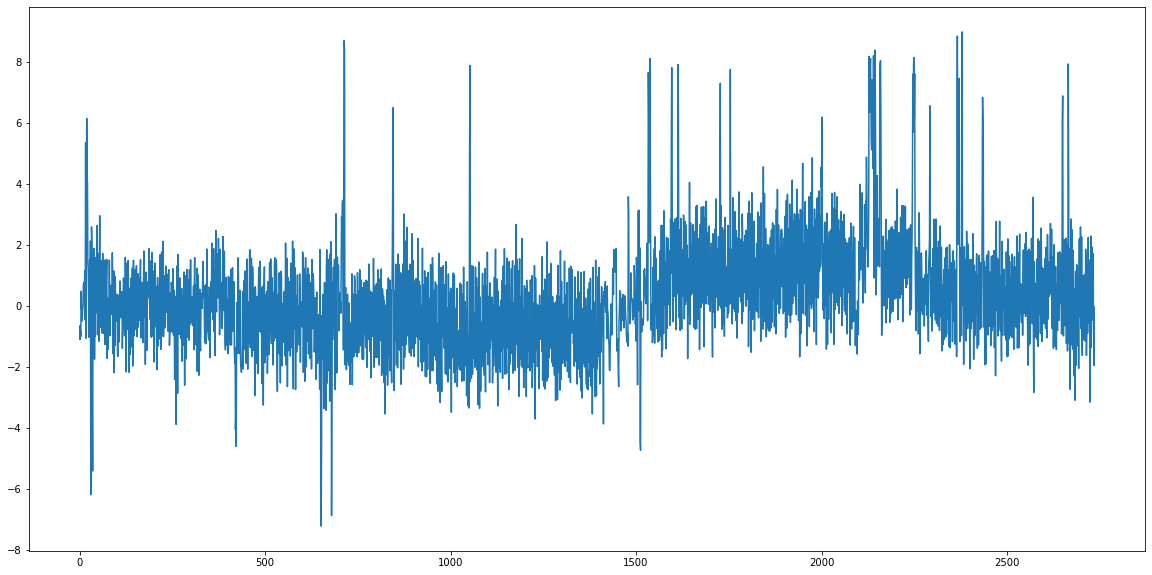

In [202]:
ASJ_data['AccX_avg'].plot(figsize=(20,10))

<AxesSubplot:>

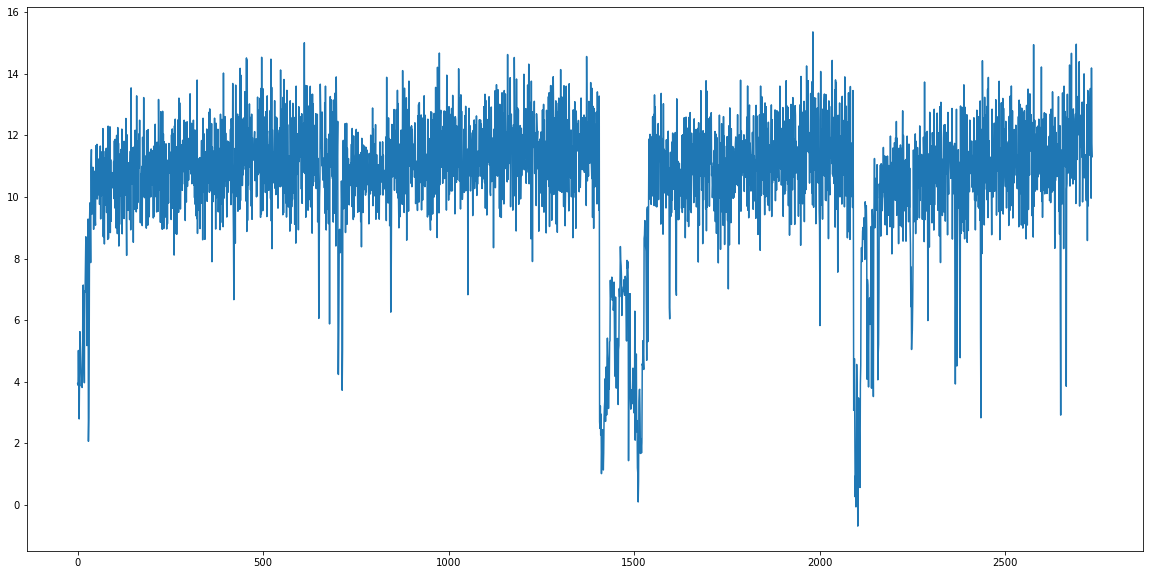

In [203]:
ASJ_data['AccY_avg'].plot(figsize=(20,10))

<AxesSubplot:>

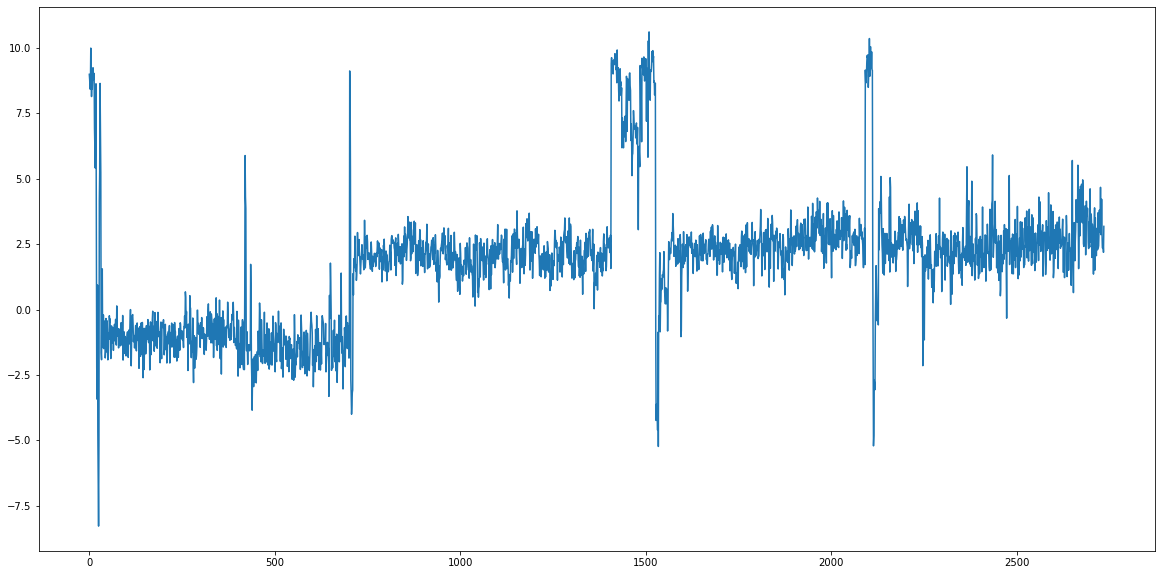

In [224]:
ASJ_data['AccZ_avg'].plot(figsize=(20,10))

<AxesSubplot:>

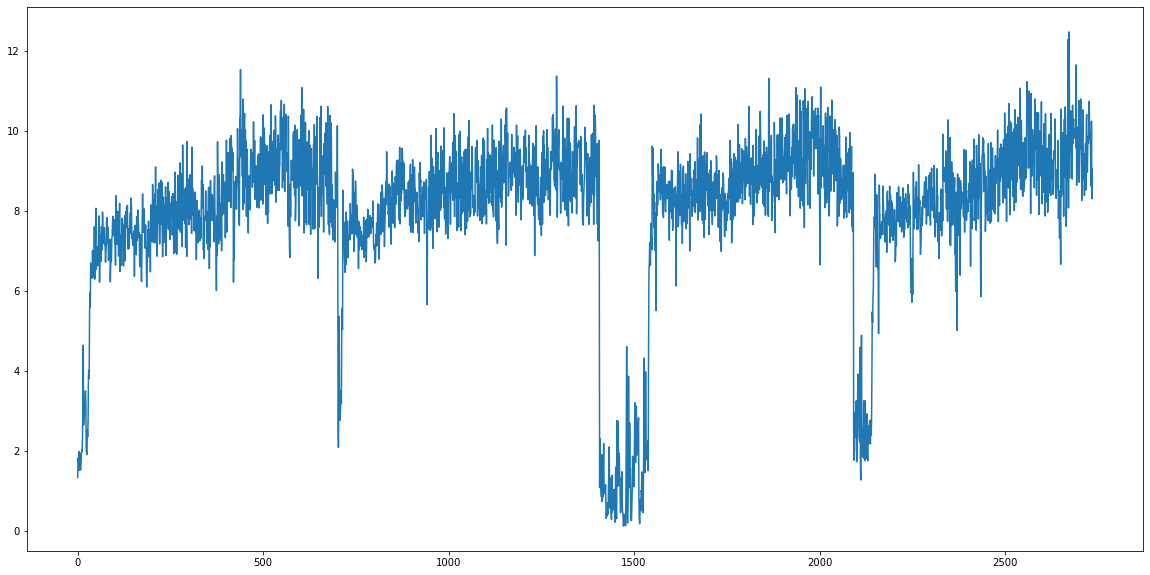

In [225]:
ASJ_data['Linear_avg'].plot(figsize=(20,10))

<AxesSubplot:>

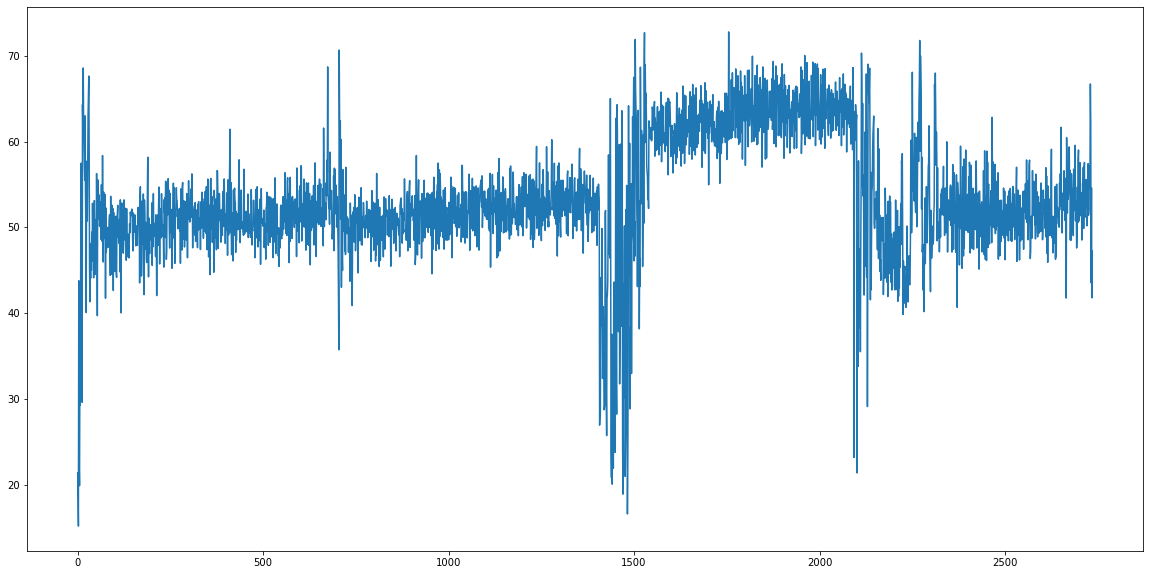

In [200]:
ASJ_data['Decibel_avg'].plot(figsize=(20,10))